In [1]:
import torch
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
#creating instance of the environment.
env = gym.make('Taxi-v3')
n_state = env.observation_space.n
print("Total No. of States:", n_state)
n_action = env.action_space.n
print("Total No. of Actions:", n_action)

Total No. of States: 500
Total No. of Actions: 6


In [3]:
#manual representation of how the taxi is going to perform pick-up/drop-off.
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
#steps taken by taxi to move towards passenger for pick-up.
print(env.step(1))
print(env.step(3))
print(env.step(0))
print(env.step(0))
print(env.step(4))
env.render()

(231, -1, False, {'prob': 1.0})
(211, -1, False, {'prob': 1.0})
(311, -1, False, {'prob': 1.0})
(411, -1, False, {'prob': 1.0})
(419, -1, False, {'prob': 1.0})
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)


In [5]:
#steps taken by taxi to move towards destination for drop-off.
print(env.step(1))
print(env.step(1))
print(env.step(2))
print(env.step(2))
print(env.step(2))
print(env.step(0))
print(env.step(0))
print(env.step(5))
env.render()

(319, -1, False, {'prob': 1.0})
(219, -1, False, {'prob': 1.0})
(239, -1, False, {'prob': 1.0})
(259, -1, False, {'prob': 1.0})
(279, -1, False, {'prob': 1.0})
(379, -1, False, {'prob': 1.0})
(479, -1, False, {'prob': 1.0})
(475, 20, True, {'prob': 1.0})
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [6]:
#creating function for epsilon-greedy policy.
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

In [7]:
#initialization of the q-table.
n_action = env.action_space.n
Q = defaultdict(lambda: torch.zeros(n_action))

gamma = 0.9
n_episode = 10000
alpha = 0.9
epsilon = 0.6

epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

for episode in range(n_episode):
    state = env.reset()
    is_done = False
    while not is_done:
        #rand = random.uniform(0, 1)
        if (epsilon >= 0.5):
            epsilon *= 0.9999
            action = env.action_space.sample()
        elif (epsilon < 0.5):
            epsilon *= 0.999
            action = epsilon_greedy_policy(state, Q)
        next_state, reward, is_done, info = env.step(action)
        td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
        Q[state][action] += alpha * td_delta
        length_episode[episode] += 1
        total_reward_episode[episode] += reward
        if is_done:
            break
        state = next_state
policy = {}
for state, actions in Q.items():
    policy[state] = torch.argmax(actions).item()

In [8]:
length = []
for no_of_trips in range(1, 11):
    state = env.reset()
    is_done = False
    step = 0
    while not is_done and step < 50:
        # Take the action (index) that have the maximum expected future reward given that state
        action = torch.argmax(Q[state]).item()
        next_state, reward, is_done, info = env.step(action)
        #clear_output(wait=True)
        state = next_state
        step += 1
    length.append(step)
avg_len = sum(length)/10
print("Average no. of steps taken by Taxi for pickup/dropoff process: ", avg_len)

Average no. of steps taken by Taxi for pickup/dropoff process:  14.4


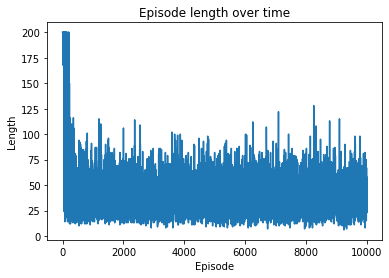

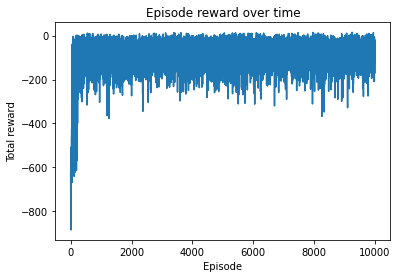

In [9]:
#plotting length and total reward for each episode over time.
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [10]:
#re-defining the Q- learning process to test different gamma, alpha and epsilon.

n_action = env.action_space.n
Q = defaultdict(lambda: torch.zeros(n_action))

def q_learning(env, gamma, n_episode, alpha):

    for episode in range(n_episode):
        state = env.reset()
        is_done = False
        while not is_done:
            action = epsilon_greedy_policy(state, Q)
            next_state, reward, is_done, info = env.step(action)
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_delta
            length_episode[episode] += 1
            total_reward_episode[episode] += reward
            if is_done:
                break
            state = next_state
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

def avg_trip_len():
    length = []
    for no_of_trips in range(1, 11):
        state = env.reset()
        is_done = False
        step = 0
        while not is_done and step < 25:
            # Take the action (index) that have the maximum expected future reward given that state
            action = torch.argmax(Q[state]).item()
            next_state, reward, is_done, info = env.step(action)
            state = next_state
            step += 1
        length.append(step)
    avg_len = sum(length)/10
    return(avg_len)

For the lowest step value from the below list, the corresponding gamma value will be selected.
[12.46 12.1  11.9  12.38 11.98 11.58]


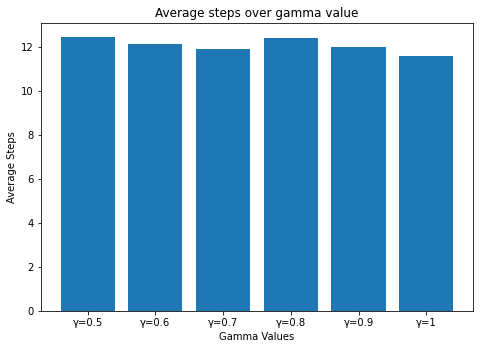

In [11]:
#finding the optimal gamma value by trying different values.
gamma = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_episode = 1000
alpha = 0.681
epsilon = 0.1
best_value = [0, 0, 0, 0, 0, 0]

epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

for j in range(1,10):
    for i in range(len(gamma)):
        q_learning(env, gamma[i], n_episode, alpha)
        best_value[i] += avg_trip_len()

print("For the lowest step value from the below list, the corresponding gamma value will be selected.") 
gamma_steps = np.array(best_value)/10
print(gamma_steps)

#plotting average steps over gamma value.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gamma_value = ['γ=0.5', 'γ=0.6', 'γ=0.7', 'γ=0.8', 'γ=0.9', 'γ=1']
ax.bar(gamma_value, gamma_steps)
plt.title('Average steps over gamma value')
plt.xlabel('Gamma Values')
plt.ylabel('Average Steps')
plt.show()

#selecting the gamma value for the corresponding minimum steps.
gamma_min = min(gamma_steps)
#print(gamma_min)
for i in range(len(gamma)):
    if gamma_min == gamma_steps[i]:
        optimal_gamma = gamma[i]
        break
#print(optimal_gamma)

For the lowest step value from the below list, the corresponding alpha value will be selected.
[12.14 12.05 11.67 11.93 11.79 11.47 11.85]


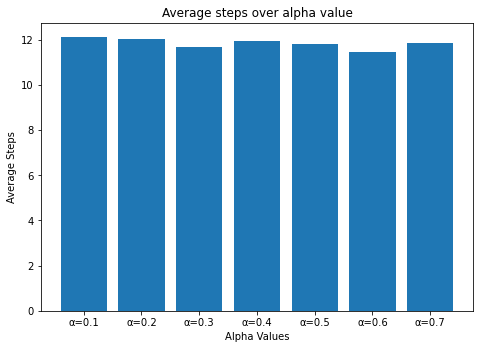

In [12]:
#finding the optimal alpha value by trying different values.
gamma = optimal_gamma
n_episode = 1000
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
epsilon = 0.1
best_value = [0, 0, 0, 0, 0, 0, 0]

epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

for j in range(1,10):
    for i in range(len(alpha)):
        q_learning(env, gamma, n_episode, alpha[i])
        best_value[i] += avg_trip_len()

print("For the lowest step value from the below list, the corresponding alpha value will be selected.") 
alpha_steps = np.array(best_value)/10
print(alpha_steps)

#plotting average steps over alpha value.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
alpha_value = ['α=0.1', 'α=0.2', 'α=0.3', 'α=0.4', 'α=0.5', 'α=0.6', 'α=0.7']
ax.bar(alpha_value, alpha_steps)
plt.title('Average steps over alpha value')
plt.xlabel('Alpha Values')
plt.ylabel('Average Steps')
plt.show()

#selecting the gamma value for the corresponding minimum steps.
alpha_min = min(alpha_steps)
#print(alpha_min)
for i in range(len(alpha)):
    if alpha_min == alpha_steps[i]:
        optimal_alpha = alpha[i]
        break
#print(optimal_alpha)

For the lowest step value from the below list, the corresponding epsilon value will be selected.
[11.59 11.77 11.73 11.84]


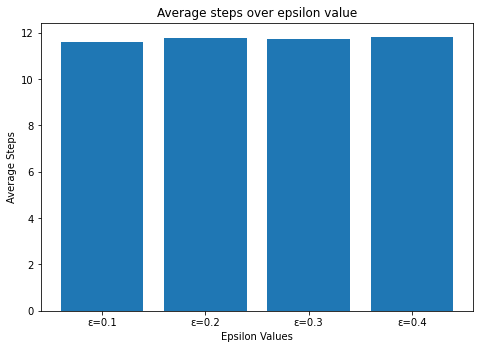

In [13]:
#finding the optimal epsilon value by trying different values.
gamma = optimal_gamma
n_episode = 1000
alpha = optimal_alpha
epsilon = [0.1, 0.2, 0.3, 0.4]
best_value = [0, 0, 0, 0]


length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

for j in range(1,10):
    for i in range(len(epsilon)):
        epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon[i])
        q_learning(env, gamma, n_episode, alpha)
        best_value[i] += avg_trip_len()

print("For the lowest step value from the below list, the corresponding epsilon value will be selected.")         
epsilon_steps = np.array(best_value)/10
print(epsilon_steps)

#plotting average steps over epsilon value.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
epsilon_value = ['ε=0.1', 'ε=0.2', 'ε=0.3', 'ε=0.4']
ax.bar(epsilon_value, epsilon_steps)
plt.title('Average steps over epsilon value')
plt.xlabel('Epsilon Values')
plt.ylabel('Average Steps')
plt.show()

#selecting the gamma value for the corresponding minimum steps.
epsilon_min = min(epsilon_steps)
#print(epsilon_min)
for i in range(len(epsilon)):
    if epsilon_min == epsilon_steps[i]:
        optimal_epsilon = epsilon[i]
        break
#print(optimal_epsilon)

In [14]:
#after getting the best values for each parameter, lets test again.
gamma = optimal_gamma
n_episode = 1000
alpha = optimal_alpha
epsilon = optimal_epsilon
best_value = []


length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

for j in range(1,10):
    epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)
    q_learning(env, gamma, n_episode, alpha)
    best_value.append(avg_trip_len())

print("Average no. of steps taken: ")    
print(sum(best_value)/10)

Average no. of steps taken: 
12.12
